In [1]:
%retina

UsageError: Line magic function `%retina` not found.


In [1]:
pwd

'/private/home/jeanremi/project/jrr/code/meg_experiment'

In [2]:
%matplotlib inline

import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import time
import submitit
from scipy.stats import wilcoxon
import seaborn as sns
import pandas as pd
import mne
from copy import deepcopy

from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_1samp, wilcoxon
import spacy

from models import Forward, Backward, B2B, CCA, PLS, RegCCA
from common import log_files, data_path
from base import fetch_data

In [63]:
def run(subject, model_name, overwrite=False, 
        folder='jrr_iclr', refit_knockout=False,
        word_emb=False):
    """Loop Granger score for each time sample independently"""
    start = time.time()
    print(start)
    
    # Paths
    preproc_path = op.join(data_path, '..', folder, 
                           '%s-preproc.pkl' % subject.subject)
    save_path = op.join(data_path, '..', folder, 
                        '%s-%s%s%s.pkl' % (subject.subject, model_name, 
                                         ['', '_refit'][refit_knockout],
                                         ['', '_wordemb'][word_emb]))
    
    # Don't compute if already exists
    if op.isfile(save_path) and not overwrite:
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    # Load and preprocess data
    if op.isfile(preproc_path):
        with open(preproc_path, 'rb') as f:
            meg, times, features, names, words = pickle.load(f)
    else:
        meg, times, features, names, words = fetch_data(subject)
        with open(preproc_path, 'wb') as f:
            pickle.dump([meg, times, features, names, words], f)
    
    cv = KFold(5, shuffle=True)    
    n_features = features.shape[1]
    _, n_channels, n_times = meg.shape
    
    if word_emb:
        nlp = spacy.load('nl_core_news_sm')
        embedding = scale([w.vector[:10] for w in map(nlp, words.values)])
        features = np.c_[features, embedding]
        n_features = features.shape[1]
    
    # Prepare model
    max_comp = min(meg.shape[1], n_features)
    comp_sweep = np.unique(np.floor(np.linspace(1, max_comp, 20))).astype(int)
    alpha_sweep = np.logspace(-4, 4, 20)

    models = dict(B2B=B2B(alpha_sweep),
                  B2B_ensemble=B2B(alpha_sweep, ensemble=20),
                  Backward=Backward(alpha_sweep),
                  Forward=Forward(alpha_sweep),
                  
                  CCA=GridSearchCV(CCA(), dict(n_components=comp_sweep), cv=5),
                  RegCCA=GridSearchCV(RegCCA(), dict(alpha=alpha_sweep), cv=5),
                  PLS=GridSearchCV(PLS(), dict(n_components=comp_sweep), cv=5),
                  
                  CCA1=CCA(1),
                  CCA2=CCA(2),
                  CCA3=CCA(3),
                  CCA4=CCA(4),
                  CCA6=CCA(6),
                  
                  PLS1=PLS(1),
                  PLS2=PLS(2),
                  PLS3=PLS(3),
                  PLS4=PLS(4),
                  PLS6=PLS(6),
                 )
    
    print(subject.subject, model_name)


    H_r = np.zeros((cv.n_splits, n_times, n_features))
    K_r = np.zeros((cv.n_splits, n_times, n_features))

    # Loop across times
    scoring = 'r'
    
    for t in trange(n_times):
        for split, (train, test) in enumerate(cv.split(features)):
            # Preprocess
            X = StandardScaler().fit(features[train]).transform(features)
            Y = StandardScaler().fit(meg[train, :, t]).transform(meg[:, :, t])
            
            # Fit model
            model = models[model_name]
            model.fit(X[train], Y[train])
            
            # Extract best model in case of grid search
            if isinstance(model, GridSearchCV):
                model = model.best_estimator_
            
            # Compute standard scores
            H = model.score(X[test], Y[test], 
                            scoring=scoring, 
                            multioutput='raw')
            
            # Aggregate score across predicted dimensions

            if 'B2B' not in model_name:
                H = [H.mean(),] * n_features
            assert len(H) == n_features

            H_r[split, t] = H
            
            # Compute knock out scores
            for f in range(n_features):
                
                # Setup knockout
                K = np.eye(n_features)
                K[f] = 0
                
                # refit the model
                test_model = model
                if refit_knockout:
                    test_model = deepcopy(model)
                    if 'B2B' in model_name:
                        test_model.fit_H(X[train] @ K, Y[train])
                    else:
                        test_model.fit(X[train] @ K, Y[train])
                
                # Score
                R = test_model.score(X[test] @ K, Y[test],
                                     scoring=scoring,
                                     multioutput='raw')
                
                # Aggregate predicted dimensions
                R = R[f] if 'B2B' in model_name else R.mean()
                
                K_r[split, t, f] = R

    # Mean scores across splits
    H_r = H_r.mean(0)
    K_r = K_r.mean(0)
    
    # Save
    print('save')
    with open(save_path, 'wb') as f:
        pickle.dump([H_r, K_r], f)

    print(time.time() - start)
    
    return H_r, K_r

In [108]:

models = dict(B2B=B2B(alpha_sweep),
              B2B_ensemble=B2B(alpha_sweep, ensemble=20),
              Backward=Backward(alpha_sweep),
              Forward=Forward(alpha_sweep),

              CCA=GridSearchCV(CCA(), dict(n_components=comp_sweep), cv=5),
              RegCCA=GridSearchCV(RegCCA(), dict(alpha=alpha_sweep), cv=5),
              PLS=GridSearchCV(PLS(), dict(n_components=comp_sweep), cv=5),
             )

In [ ]:
subject=log_files.iloc[0]
model_name='CCA'
overwrite=False
folder='jrr_iclr'
refit_knockout=False
word_emb=False

# Paths
preproc_path = op.join(data_path, '..', folder, 
                       '%s-preproc.pkl' % subject.subject)
save_path = op.join(data_path, '..', folder, 
                    '%s-%s%s%s.pkl' % (subject.subject, model_name, 
                                     ['', '_refit'][refit_knockout],
                                     ['', '_wordemb'][word_emb]))


# Load and preprocess data
if op.isfile(preproc_path):
    with open(preproc_path, 'rb') as f:
        meg, times, features, names, words = pickle.load(f)
else:
    meg, times, features, names, words = fetch_data(subject)
    with open(preproc_path, 'wb') as f:
        pickle.dump([meg, times, features, names, words], f)

cv = KFold(5, shuffle=True)    
n_features = features.shape[1]
_, n_channels, n_times = meg.shape

if word_emb:
    nlp = spacy.load('nl_core_news_sm')
    embedding = scale([w.vector[:10] for w in map(nlp, words.values)])
    features = np.c_[features, embedding]
    n_features = features.shape[1]

# Prepare model
max_comp = min(meg.shape[1], n_features)
comp_sweep = np.unique(np.floor(np.linspace(1, max_comp, 20))).astype(int)
alpha_sweep = np.logspace(-4, 4, 20)


model = GridSearchCV(CCA(), dict(n_components=comp_sweep), cv=5)
model = B2B(alpha_sweep)

H_r = np.zeros((cv.n_splits, n_times, n_features))
K_r = np.zeros((cv.n_splits, n_times, n_features))

# Loop across times
scoring = 'r'

In [117]:
t = 16
t=31
for split, (train, test) in enumerate(cv.split(features)):
    # Preprocess
    X = StandardScaler().fit(features[train]).transform(features)
    Y = StandardScaler().fit(meg[train, :, t]).transform(meg[:, :, t])

    # Fit model
    model = models[model_name]
    model.fit(X[train], Y[train])

    # Extract best model in case of grid search
    if isinstance(model, GridSearchCV):
        model = model.best_estimator_

    # Compute standard scores
    H = model.score(X[test], Y[test], 
                    scoring=scoring, 
                    multioutput='raw')

    # Aggregate score across predicted dimensions

    if 'B2B' not in model_name:
        H = [H.mean(),] * n_features
    assert len(H) == n_features

    H_r[split, t] = H

    # Compute knock out scores
    for f in range(n_features):

        # Setup knockout
        K = np.eye(n_features)
        K[f] = 0

        # refit the model
        test_model = model

        # Score
        R = test_model.score(X[test] @ K, Y[test],
                             scoring=scoring,
                             multioutput='raw')

        # Aggregate predicted dimensions
        R = R[f] if 'B2B' in model_name else R.mean()

        K_r[split, t, f] = R
        0/0

TypeError: score() got an unexpected keyword argument 'scoring'

In [123]:
CCA?

In [122]:
t=31
Y = StandardScaler().fit(meg[train, :, t]).transform(meg[:, :, t])
for m in (CCA(1), CCA(2), CCA(3)):
    m.fit(X[train], Y[train])
    H = m.score(X[test], Y[test])
    
    scores = list()
    for f in range(n_features):

        # Setup knockout
        K = np.eye(n_features)
        K[f] = 0


        # Score
        R = model.score(X[test] @ K, Y[test])
        scores.append(H-R)
    print(scores)

[0.005947733914491493, 0.04111036749275354, -0.001082497145223904, 0.0036142004076334944]
[-0.15657389097876365, -0.1214112574005016, -0.16360412203847904, -0.15890742448562165]
[-0.2191674836247654, -0.18400485004650335, -0.2261977146844808, -0.2215010171316234]


In [118]:
model.best_estimator_

CCA(multioutput='uniform_average', n_components=1, scoring='r', tol=1e-15)

In [ ]:
folder = 'jrr_iclr'
preproc_path = op.join(data_path, '..', folder,
                       '%s-preproc.pkl' % log_files.iloc[0].subject)

with open(preproc_path, 'rb') as f:
    _, times, features, names, _ = pickle.load(f)

In [77]:
log_path = op.join(data_path, '..', 'jrr_iclr', 'log')
executor = submitit.AutoExecutor(folder=log_path)
executor.update_parameters(timeout_min=4*60, 
                           partition='learnfair,uninterrupted,scavenge',
                           constraint='pascal', cpus_per_task=10)

jobs3 = list()
models = (
    'B2B', 
    'Forward',
    'CCA',
    'PLS',
    'RegCCA',
)
#models = ('B2B_ensemble',)
folder = 'jrr_iclr'
refit_knockout = True
word_emb = False
save_path = op.join(data_path, '..', folder, '%s-%s%s%s.pkl') 

for subject in trange(len(log_files)):
    for model_name in models:
        subject_info = log_files.iloc[subject]
        if op.isfile(save_path % (subject_info.subject, model_name, 
                                  ['', '_refit'][refit_knockout],
                                  ['', '_wordemb'][word_emb])):
            continue
        jobs3.append([subject_info, model_name, True, folder, refit_knockout, word_emb])
print(len(jobs3))
jobs3 = executor.map_array(run, *zip(*jobs3))




  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 951.70it/s]


100%|██████████| 100/100 [00:00<00:00, 935.54it/s]

500


In [6]:
times = np.linspace(-.100, 1., 67)

In [105]:
def get_results(model_name, folder='jrr_iclr', refit_knockout=False, word_emb=False):
    
    H_r, K_r = list(), list()
    for subject in range(len(log_files)):
        subject = log_files.loc[subject, 'subject']
        save_path = op.join(data_path, '..', folder, 
                            '%s-%s%s%s.pkl' % (subject, model_name, 
                                           ['', '_refit'][refit_knockout],
                                           ['', '_wordemb'][word_emb]))
        if op.isfile(save_path):
            with open(save_path, 'rb') as f:
                hr, kr = pickle.load(f)
            
            if hr.shape[1] != 4 or len(hr.shape) != 2:
                continue
            
            H_r.append(hr)
            K_r.append(kr)

    H_r, K_r = np.array(H_r), np.array(K_r)
    return H_r, K_r

In [106]:
models = [
          #'Backward', 
          'Forward',
          'PLS',
          'CCA',
          'RegCCA',
          'B2B', 
]
features = ('Word Length', 'Word Frequency', 'Word Function', 'Dummy Variable')

data = list()
for model_name in models:
    H_r, K_r = get_results(model_name, refit_knockout=False)
    print(len(H_r))

    scores = H_r - K_r
    for effect_idx, effect in enumerate(features):
        for subject, score in enumerate(scores):
            for t, (time, r) in enumerate(zip(times, score)):
                data.append(dict(subject=subject, effect=effect, model=model_name, 
                                 r=scores[subject, t, effect_idx], time=int(time*1e3)))
data = pd.DataFrame(data)

93
93
93
92
93


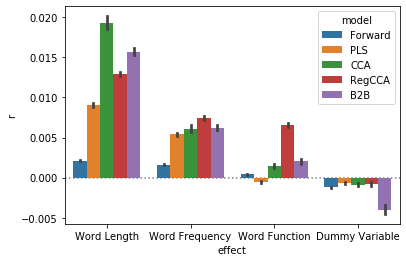

In [102]:
sns.barplot(x='effect', y='r', 
            hue='model', data=data.query('time>0'))
plt.axhline(0, color='gray', ls=':', zorder=-1)
#plt.ylim(-.01, .05)

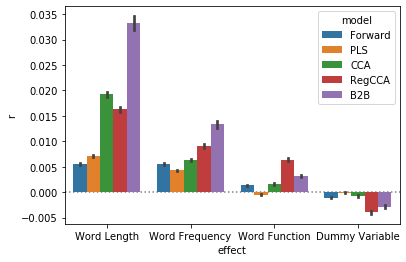

In [164]:
sns.barplot(x='effect', y='r', 
            hue='model', data=data.query('time>0'))
plt.axhline(0, color='gray', ls=':', zorder=-1)
#plt.ylim(-.01, .05)

/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


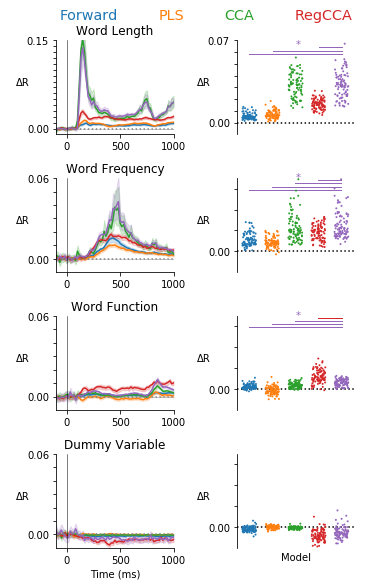

In [85]:
fig, axes = plt.subplots(4, 2, figsize=[5, 8])

for ax, effect in zip(axes[:, 0], features):
    sns.lineplot(x='time', y='r', hue='model', 
                 data=data.query('effect==@effect'),
                 ax=ax, legend=False)
    ax.axhline(0, color='gray', ls=':')

    ax.set_ylabel('ΔR').set_rotation(0)
    ax.axvline(0, color='k', lw=.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(effect)

    ylim = 0.06 if effect != 'Word Length' else 0.15
    ax.set_yticks(np.arange(0, ylim+.001, .01))
    ax.set_ylim(-.01, ylim)
    ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else ''
                           for f in np.arange(0, ylim+.001, .01)])
    ax.set_xlim(-100, 1000)
    ax.axhline(0, color='k', ls=':', zorder=-10, lw=.5)
    ax.set_xlabel('')
ax.set_xlabel('Time (ms)')

for feature, ax in zip(features, axes[:, 1]):
    d = data.query('effect==@feature and time>0 and time <1000')
    d = d.groupby(('subject', 'model'), as_index=False).mean()
    sns.stripplot(x='model', y='r', dodge=True, order=models,
                  s=2, jitter=.3, data=d, ax=ax)
    # legend clean up
    ax.axhline(0,color='k', ls=':')
    ax.legend().set_visible(False)
    ylim = 0.035 if feature != 'Word Length' else 0.07
    ax.set_ylim(-.01, ylim)
    ax.set_yticks(np.arange(0, ylim+.001, .01))
    ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else '' 
                        for f in np.arange(0, ylim+.001, .01)])
    ax.set_ylabel('ΔR').set_rotation(0)
    ax.set_xticks([])
    ax.set_xlabel('')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # statistical comparison
    if feature == 'Dummy Variable':
        continue

    space = np.ptp(ax.get_ylim()) / 30
    k = 0
    for idx, m1 in enumerate(models):

        r = list()
        _, p = wilcoxon(d.query('model == @m1').r.values)
        # print('%s: %s: %.4f' % (feature, m1, p))
        
        for jdx, m2 in enumerate(models):
            if m1 == m2:
                continue
            r = list()
            d.query('model==@m1').r.values
            for _, subject in d.query('model in [@m1, @m2]').groupby('subject'):
                if len(subject)==2:
                    r.append([subject.query('model==@m1').r.values[0],
                              subject.query('model==@m2').r.values[0]])
            r1, r2 = np.transpose(r)
            u, p = wilcoxon(r1, r2)
            if m1 == 'B2B' and feature != 'dummy':
                #print('%s: b2b versus %s: %.4f' % (feature, m2, p))
                pass
            if p < .05 and 'B2B' == m2:
                k += 1
                y = .8 * ylim + k * space
                if np.median(r1) > np.median(r2):
                    color = 'C%i' % idx
                else:
                    color = 'C%i' % jdx
                    
                ax.plot(np.linspace(0, 4, 5)[[idx, jdx]], 
                        [y, y], color=color, lw=1.)
    ax.text(2, y, '*', color='C4')
ax.set_xlabel('Model')

# legend
lines = [ax.plot([0, 0], [0,0], color='C%i' % i)[0] for i in range(4)]
lines = [ax.plot([0, 0], [0,0], color='w')[0]] + lines
leg = plt.figlegend(lines, ['',] + models, loc='upper center', 
                    ncol=6, labelspacing=0., fontsize='x-large',
                    handlelength=0, frameon=False,
                    bbox_to_anchor=(0.5,1.025))

for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

fig.tight_layout()

In [78]:
log_path = op.join(data_path, '..', 'jrr_iclr', 'log')
executor = submitit.AutoExecutor(folder=log_path)
executor.update_parameters(timeout_min=4*60, 
                           partition='learnfair,uninterrupted,scavenge',
                           constraint='pascal', cpus_per_task=10)

jobs4 = list()
models = (
    'B2B',
    'Forward',
    'CCA',
    'PLS',
    'RegCCA',
)
#models = ('B2B_ensemble',)
folder = 'jrr_iclr'
refit_knockout = False
word_emb = True
save_path = op.join(data_path, '..', folder, '%s-%s%s%s.pkl') 

for subject in trange(len(log_files)):
    for model_name in models:
        subject_info = log_files.iloc[subject]
        if op.isfile(save_path % (subject_info.subject, model_name, 
                                  ['', '_refit'][refit_knockout],
                                  ['', '_wordemb'][word_emb])):
            continue
        jobs4.append([subject_info, model_name, True, folder, refit_knockout, word_emb])
print(len(jobs3))
jobs4 = executor.map_array(run, *zip(*jobs4))




  0%|          | 0/100 [00:00<?, ?it/s]


 69%|██████▉   | 69/100 [00:00<00:00, 685.04it/s]


100%|██████████| 100/100 [00:00<00:00, 738.47it/s]

500


In [81]:
jobs4[0]

SlurmJob<job_id=19929102_0, task_id=0, state="COMPLETED">